In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import llama.plotting.plotters as p
import llama.api.options as opts
import numpy as np
from importlib import reload
import llama
from llama.dev_utils import reload_module_recursively
import copy
from llama.io.loaders.xrf.api import load_data_from_xrf_format

In [2]:
# Load the XRF data
folder = "/net/micdata/data3/hruth/xrf_data/Tomo-3-new/"
xrf_standard_data_dict = load_data_from_xrf_format(folder)

100%|██████████| 93/93 [00:14<00:00,  6.45it/s]


In [3]:
# Convert the XRF data into a dictionary of arrays, where each
# dictionary key corresponds to a channel
from llama.io.loaders.xrf.api import convert_xrf_projection_dicts_to_arrays
xrf_array_dict = convert_xrf_projection_dicts_to_arrays(
    xrf_standard_data_dict,
    pad_with_mode=True,
)

Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 850.79it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1145.90it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1157.84it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1149.57it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1054.34it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1061.75it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1108.59it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1103.19it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1096.96it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1061.93it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1066.92it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1030.64it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1041.00it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1061.57it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1097.82it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1068.93it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1101.36it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1109.83it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1017.14it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1027.97it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1058.39it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1046.04it/s]

Fixing projections dimensions...Completed


In [4]:
# Insert the data into an XRFTask object
from llama.data_structures.xrf_object import XRFTask
# Just use angles from the first one
k = "Al"
xrf_task = XRFTask(
    xrf_array_dict=xrf_array_dict,
    angles=xrf_standard_data_dict[k].angles,
    scan_numbers=xrf_standard_data_dict[k].scan_numbers,
    task_options=opts.AlignmentTaskOptions(),
    projection_options=opts.ProjectionOptions(),
    primary_channel="Total_Fluorescence_Yield",
)
# The primary_channel designates which channel of data is used in alignment calculations.
# This can be changed at any time.

In [14]:
xrf_task.primary_channel

'Total_Fluorescence_Yield'

An error occurred: NotImplementedError: This function does not work to check if arrays smaller than 200 bytes


Traceback (most recent call last):
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/gpu_utils.py", line 147, in wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/timing/timer_utils.py", line 113, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/alignment/cross_correlation.py", line 33, in run
    illum_sum = pin_memory(illum_sum)
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/timing/timer_utils.py", line 113, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/gpu_utils.py", line 71, in pin_memory
    if force_repin or not is_pinned(array):
                          ^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_developme

TypeError: 'NoneType' object is not subscriptable

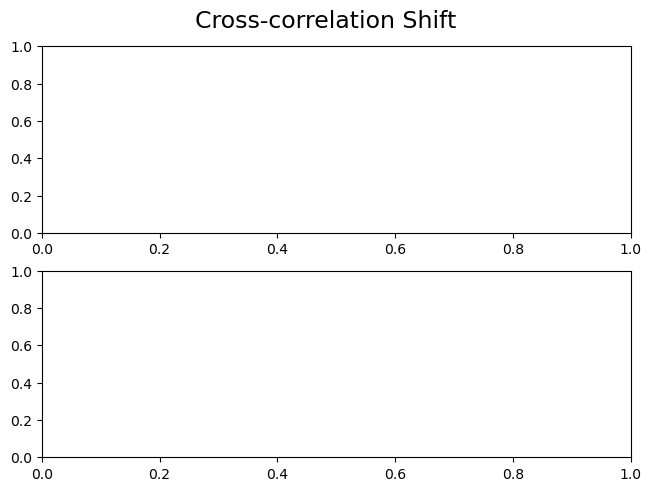

In [5]:
# Update cross-correlation options and run the alignment
xrf_task.task_options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=1,
    filter_position=10,
    filter_data=0.005,
    precision=0.01,
    remove_slow_variation=False,
)
xrf_task.get_cross_correlation_shift()

An error occurred: NotImplementedError: This function does not work to check if arrays smaller than 200 bytes


Traceback (most recent call last):
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/gpu_utils.py", line 147, in wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/timing/timer_utils.py", line 113, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/alignment/cross_correlation.py", line 33, in run
    illum_sum = pin_memory(illum_sum)
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/timing/timer_utils.py", line 113, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_development/llama/src/llama/gpu_utils.py", line 71, in pin_memory
    if force_repin or not is_pinned(array):
                          ^^^^^^^^^^^^^^^^
  File "/home/beams0/HRUTH/code/lamino_developme

TypeError: 'NoneType' object is not subscriptable

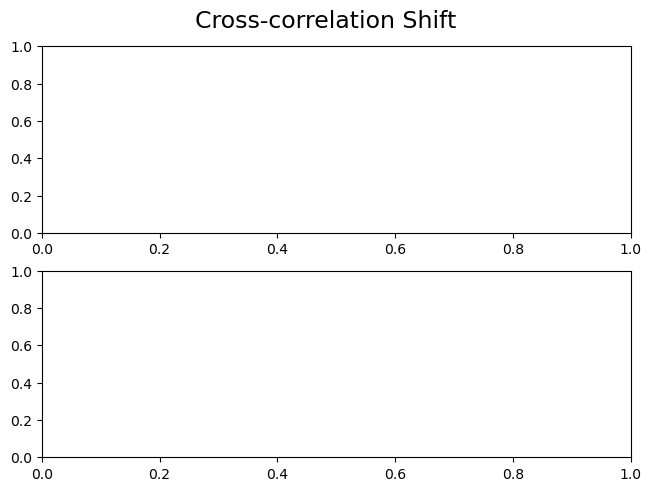

In [18]:
# Update cross-correlation options and run the alignment
xrf_task.task_options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=1,
    filter_position=10,
    filter_data=0.005,
    precision=0.01,
    remove_slow_variation=False,
)
xrf_task.get_cross_correlation_shift()

In [17]:
xrf_task.projections_dict[xrf_task.primary_channel].data.shape

(93, 128, 448)

In [6]:
xrf_task.channels

dict_keys(['Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Total_Fluorescence_Yield', 'Sum_Elastic_Inelastic'])

interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=92)

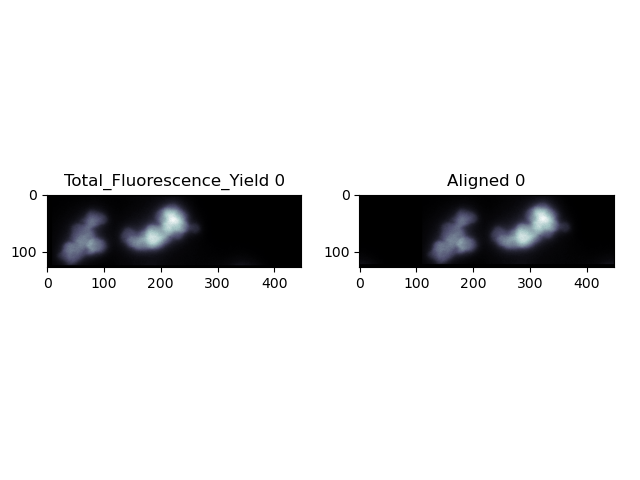

In [14]:
# Plot the results
%matplotlib widget
sort_idx = np.argsort(xrf_task.angles)
xrf_task.plot_alignment_results(["Total_Fluorescence_Yield"], sort_idx = sort_idx)

In [ ]:
# Finally, apply the cross-correlation_shift
xrf_task.apply_staged_shift_to_all_channels()

In [ ]:
print(list(xrf_task.channels))

['Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Total_Fluorescence_Yield', 'Sum_Elastic_Inelastic']


interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=92)

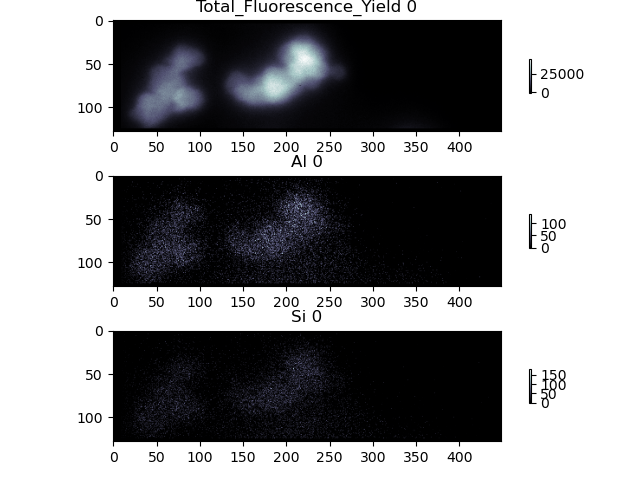

In [8]:
plot_options = opts.ImageSliderPlotOptions(image=opts.PlotDataOptions(colorbar=True))
xrf_task.plot_xrf_channels(
    channels=["Total_Fluorescence_Yield", "Al", "Si"],
    plot_options=plot_options,
    subplot_dims=(3, 1),
)

In [ ]:
xrf_task.drop_projections_from_all_channels(remove_idx=[95, 96, 97, 98])

In [1]:
plot_options = opts.ImageSliderPlotOptions(image=opts.PlotDataOptions(colorbar=True))
xrf_task.plot_xrf_channels(
    channels=["Total_Fluorescence_Yield", "Al", "Si"],
    plot_options=plot_options,
    subplot_dims=(3, 1),
)

NameError: name 'opts' is not defined